In [1]:

# ==========================================
# IMPORTS
# ==========================================
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
# 1. HYPERPARAMETERS (Optimized and Fixed)
# ==========================================
CONFIG = {
    'batch_size': 256,        
    'lr': 1e-4,               # Base learning rate
    'warmup_epochs': 10,       # Learning rate warmup
    'weight_decay': 0.05,
    'epochs': 300,             
    'img_size': 224,
    'embed_dim': 192,
    'num_heads': 3,
    'enc_depth': 6,
    'pred_depth': 6,
    'patch_size': 16,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'mask_scale': (0.2, 0.3),
    'context_scale': (0.5, 0.7),
    'num_targets': 4,         # Number of target blocks
    'ema_momentum_base': 0.996,  # Will be adjusted based on epochs
    'patience': 10,           # Early stopping patience
    'min_context_patches': 20,  # Minimum visible patches in context
    'center_crop_size': 140,  # Crop size for galaxies
}
# Adjust EMA momentum based on training length
if CONFIG['epochs'] < 100:
    CONFIG['ema_momentum'] = 0.99  # Lower momentum for shorter training
else:
    CONFIG['ema_momentum'] = CONFIG['ema_momentum_base']

print(f"Running on: {CONFIG['device']}")
print(f"Training for {CONFIG['epochs']} epochs with EMA momentum: {CONFIG['ema_momentum']}")

Running on: cuda
Training for 300 epochs with EMA momentum: 0.996


In [4]:

# ==========================================
# 2. DATASET
# ==========================================
class Galaxy10FullDataset(Dataset):
    """
    Galaxy10 Dataset that loads all data into RAM for fast training.
    """
    def __init__(self, file_path, transform=None):
        self.transform = transform
        
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dataset file not found: {file_path}")

        try:
            print(f"Loading {file_path} into RAM...")
            with h5py.File(file_path, "r") as f:
                self.images = f["images"][:]  # Shape: (N, 256, 256, 3)
                self.labels = f["ans"][:]
            
            # Ensure correct type for PIL (0-255 uint8)
            self.images = self.images.astype(np.uint8)
            self.N = len(self.images)
            print(f"✓ Loaded {self.N} images into RAM. Ready to train.")
            
        except Exception as e:
            raise RuntimeError(f"Failed to load dataset: {str(e)}")

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Convert to PIL Image for torchvision transforms
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, int(label)


class TransformDataset(Dataset):
    """
    Wraps any dataset or subset and applies a new transform
    without modifying the original dataset.
    """
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        item = self.subset[idx]

        if isinstance(item, tuple):
            img, label = item
            return self.transform(img), label

        return self.transform(item)



In [5]:
import torch
import numpy as np

# ==========================================
# 3. MASKING UTILITIES (Galaxy-aware JEPA)
# ==========================================
class IJepaMaskCollator:
    """
    Galaxy-aware masking collator for Mini-JEPA on Galaxy10.

    Returns:
        images:        (B, C, H, W)
        context_mask:  (B, N) bool, True = visible to context encoder
        target_masks:  list of length num_targets, each (B, N) bool, True = target block
    """

    def __init__(
        self,
        input_size=224,
        patch_size=32,
        enc_mask_scale=(0.4, 0.8),   # size of VISIBLE context block, in fraction of grid dims
        pred_mask_scale=(0.2, 0.3),  # size of each TARGET block, in fraction of grid dims
        num_targets=4,
        min_context_patches=10
    ):
        self.input_size = input_size
        self.patch_size = patch_size

        self.H = input_size // patch_size   # patch grid height
        self.W = input_size // patch_size   # patch grid width
        self.N = self.H * self.W

        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.num_targets = num_targets
        self.min_context_patches = min_context_patches

    # ------------------------------------------------------
    def __call__(self, batch):
        """
        batch: list of (image, label) or (image,)
        """
        # Extract images only
        images = torch.stack([item[0] for item in batch])  # (B, C, H, W)
        B = images.shape[0]

        # 1. Compute brightness per patch (so we know where the galaxy actually is)
        brightness = self._compute_patch_brightness(images)  # (B, H, W)

        # 2. Sample target masks (what the predictor must reconstruct)
        target_masks = []
        for _ in range(self.num_targets):
            t_mask = self._sample_semantic_block(brightness, self.pred_mask_scale)  # (B, N)
            target_masks.append(t_mask)

        # Combine all target blocks
        full_target_mask = torch.stack(target_masks, dim=0).any(dim=0)  # (B, N)

        # 3. Sample context mask (what the context encoder sees)
        #    This block represents the VISIBLE region.
        context_mask = self._sample_semantic_block(brightness, self.enc_mask_scale)  # (B, N)

        # Remove any overlap with target blocks
        context_mask = context_mask & (~full_target_mask)

        # 4. Ensure enough context patches remain
        for b in range(B):
            if context_mask[b].sum() < self.min_context_patches:
                # Fallback: allow every non-target patch to be context
                context_mask[b] = ~full_target_mask[b]
                # Still possible this is all False if target covers everything,
                # but with reasonable scales that should never happen.

        return images, context_mask, target_masks

    # ------------------------------------------------------
    def _compute_patch_brightness(self, imgs):
        """
        Compute mean absolute brightness per patch.

        imgs: (B, C, H, W), normalized, can be in [-1,1] or similar.
        Returns: (B, H_patches, W_patches)
        """
        B, C, H, W = imgs.shape
        assert H == self.input_size and W == self.input_size, \
            f"Expected images of size {self.input_size}x{self.input_size}, got {H}x{W}"

        # Approx "grayscale" intensity
        gray = imgs.mean(dim=1).abs()  # (B, H, W)

        # Fold into patches of size patch_size x patch_size
        p = self.patch_size
        Hp = H // p
        Wp = W // p

        # unfold: (B, Hp, Wp, p, p)
        patches = gray.unfold(1, p, p).unfold(2, p, p)
        # Mean brightness per patch
        brightness = patches.mean(dim=(-1, -2))  # (B, Hp, Wp)

        return brightness

    # ------------------------------------------------------
    def _sample_semantic_block(self, brightness, scale):
        """
        Sample a block of patches per image, biased toward bright (galaxy) regions.

        brightness: (B, H, W)
        scale: (min_frac, max_frac) of grid dims for block size
        Returns:
            mask: (B, N) bool, True where block is active (visible or target)
        """
        B, H, W = brightness.shape
        mask = torch.zeros(B, H, W, dtype=torch.bool)

        min_s, max_s = scale

        for b in range(B):
            br = brightness[b]  # (H, W)

            # pick block size as a fraction of grid dims
            block_h = np.random.randint(
                max(1, int(H * min_s)),
                max(1, int(H * max_s)) + 1
            )
            block_w = np.random.randint(
                max(1, int(W * min_s)),
                max(1, int(W * max_s)) + 1
            )

            # probability from brightness
            prob = br.flatten()  # (H*W,)

            # sanitize probs
            prob = torch.nan_to_num(prob, nan=0.0, posinf=0.0, neginf=0.0)
            prob = torch.clamp(prob, min=0.0)

            if prob.sum() <= 0:
                # if galaxy is very faint, fall back to uniform
                prob = torch.ones_like(prob)

            prob = prob / prob.sum()

            # sample center location
            idx = torch.multinomial(prob, 1).item()
            cy = idx // W
            cx = idx % W

            # convert center → top-left
            y0 = int(max(0, cy - block_h // 2))
            x0 = int(max(0, cx - block_w // 2))

            # clamp to stay inside grid
            y0 = min(y0, H - block_h)
            x0 = min(x0, W - block_w)

            y1 = y0 + block_h
            x1 = x0 + block_w

            mask[b, y0:y1, x0:x1] = True

        return mask.view(B, H * W)


In [6]:
# ==========================================
# 4. MODEL COMPONENTS
# ==========================================
class PatchEmbed(nn.Module):
    """Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=192):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)  # (B, C, H, W)
        x = x.flatten(2).transpose(1, 2)  # (B, N, C), where C is the emb_dim now
        return x


class MiniViT(nn.Module):
    """Mini Vision Transformer"""
    def __init__(self, num_patches=196, embed_dim=192, depth=3, num_heads=3):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            batch_first=True,
            norm_first=True
        )
        self.blocks = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.norm = nn.LayerNorm(embed_dim)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x, padding_mask=None):
        # x: (B, N, C)
        # padding_mask: (B, N) where True means "Ignore this token"
        x = self.blocks(x, src_key_padding_mask=padding_mask)
        return self.norm(x)


class MiniJEPA(nn.Module):
    """Mini JEPA Model"""
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # 1. Shared patch embedding
        self.patch_embed = PatchEmbed(
            img_size=config['img_size'],
            patch_size=config['patch_size'],
            embed_dim=config['embed_dim']
        )

        num_patches = (config['img_size'] // config['patch_size']) ** 2
        
        # 2. Context and target encoders
        self.context_encoder = MiniViT(
            num_patches=num_patches,
            embed_dim=config['embed_dim'],
            depth=config['enc_depth'],
            num_heads=config['num_heads']
        )
        self.target_encoder = MiniViT(
            num_patches=num_patches,
            embed_dim=config['embed_dim'],
            depth=config['enc_depth'],
            num_heads=config['num_heads']
        )

        # 3. Predictor
        self.predictor = MiniViT(
            num_patches=num_patches,
            embed_dim=config['embed_dim'],
            depth=config['pred_depth'],
            num_heads=config['num_heads']
        )

        self.mask_token = nn.Parameter(torch.zeros(1, 1, config['embed_dim']))

        self._init_weights()

        # Copy context encoder weights into target encoder and freeze
        self.target_encoder.load_state_dict(self.context_encoder.state_dict())
        for p in self.target_encoder.parameters():
            p.requires_grad = False

    def _init_weights(self):
        nn.init.trunc_normal_(self.mask_token, std=0.02)
        
    def count_parameters(self):
        """Count trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward_target(self, images):
        """Forward pass through target encoder"""
        x = self.patch_embed(images)
        x = x + self.target_encoder.pos_embed
        x = self.target_encoder(x)
        return x

    def forward_context(self, images, context_mask):
        """Forward pass through context encoder"""
        x = self.patch_embed(images)
        x = x + self.context_encoder.pos_embed

        # PyTorch Transformer uses True = ignore, so invert
        padding_mask = ~context_mask.bool()

        x = self.context_encoder(x, padding_mask=padding_mask)
        return x

    def forward_predictor(self, context_output, target_masks):
        """Predict target representations from context"""
        B, N, C = context_output.shape
        predictions = []

        pos_embed_expanded = self.predictor.pos_embed.expand(B, N, C)

        for t_mask in target_masks:
            t_mask = t_mask.bool()

            pred_input = context_output.clone()
            pred_input = pred_input + pos_embed_expanded

            mask_tokens = self.mask_token.expand(B, N, C)
            pred_input[t_mask] = mask_tokens[t_mask] + pos_embed_expanded[t_mask]

            out = self.predictor(pred_input)
            predictions.append(out)

        return predictions


In [7]:


# ==========================================
# 5. TRAINING UTILITIES
# ==========================================
class EarlyStopping:
    """Early stopping handler"""
    def __init__(self, patience=10, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


def get_lr_schedule(optimizer, warmup_epochs, total_epochs):
    """Learning rate warmup + cosine decay"""
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            return 0.5 * (1 + np.cos(np.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [8]:
# Define data path
data_path = "/kaggle/input/galaxy10-decals/Galaxy10_DECals.h5"


# Training augmentations (strong augmentation to prevent collapse)
train_transform = T.Compose([
    T.CenterCrop(CONFIG['center_crop_size']),  # Zoom in on galaxy
    T.RandomRotation(180),      # Galaxies rotate!
    T.RandomHorizontalFlip(),   # Chirality invariance
    T.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Test transform (no random augmentation!)
test_transform = T.Compose([
    T.CenterCrop(CONFIG['center_crop_size']),
    T.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

print("=" * 60)
print("Initializing Dataset")
print("=" * 60)


full_dataset = Galaxy10FullDataset(file_path=data_path, transform=None)


# Split dataset
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_subset, test_subset = random_split(
    full_dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Reproducible split
)

# Apply transforms
train_subset = TransformDataset(train_subset, train_transform)
test_subset = TransformDataset(test_subset, test_transform)

# Create collator
collator = IJepaMaskCollator(
    input_size=CONFIG['img_size'],
    patch_size=CONFIG['patch_size'],
    enc_mask_scale=CONFIG['context_scale'],
    pred_mask_scale=CONFIG['mask_scale'],
    num_targets=CONFIG['num_targets'],
    min_context_patches=CONFIG['min_context_patches']
)

# DataLoaders (num_workers=0 since data is in RAM)
train_loader = DataLoader(
    train_subset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True,
    collate_fn=collator, 
    drop_last=True, 
    num_workers=2,  # 0 for in-RAM dataset
    pin_memory=True
)
test_loader = DataLoader(
    test_subset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False,
    collate_fn=collator, 
    drop_last=False, 
    num_workers=3,
    pin_memory=True
)

print(f"✓ Train samples: {len(train_subset)}, Test samples: {len(test_subset)}")
print(f"✓ Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

# Initialize model
print("\n" + "=" * 60)
print("Initializing Model")
print("=" * 60)

model = MiniJEPA(CONFIG).to(CONFIG['device'])
print(f"✓ Model parameters: {model.count_parameters():,}")

# Optimizer and scheduler
optimizer = optim.AdamW(
    model.parameters(), 
    lr=CONFIG['lr'], 
    weight_decay=CONFIG['weight_decay']
)
scheduler = get_lr_schedule(
    optimizer, 
    CONFIG['warmup_epochs'], 
    CONFIG['epochs']
)
scaler = GradScaler()
early_stopping = EarlyStopping(patience=CONFIG['patience'])


Initializing Dataset
Loading /kaggle/input/galaxy10-decals/Galaxy10_DECals.h5 into RAM...
✓ Loaded 17736 images into RAM. Ready to train.
✓ Train samples: 15962, Test samples: 1774
✓ Train batches: 62, Test batches: 7

Initializing Model
✓ Model parameters: 5,562,240


In [9]:
# ==========================================
# 6. TRAINING LOOP
# ==========================================
def train():

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'lr': []
    }
    best_val_loss = float('inf')

    print("\n" + "=" * 60)
    print(f"Starting Training on {CONFIG['device']}")
    print("=" * 60)

    for epoch in range(CONFIG["epochs"]):
        # ============ TRAINING ============
        model.train()
        total_loss = 0.0
        num_batches = 0

        for i, (images, context_mask, target_masks) in enumerate(train_loader):
            images = images.to(CONFIG["device"], non_blocking=True)
            context_mask = context_mask.to(CONFIG["device"], non_blocking=True)
            target_masks = [m.to(CONFIG["device"], non_blocking=True) for m in target_masks]

            optimizer.zero_grad(set_to_none=True)

            try:
                with autocast():
                    # Forward pass
                    with torch.no_grad():
                        target_output = model.forward_target(images)
                    
                    context_output = model.forward_context(images, context_mask)
                    predictions = model.forward_predictor(context_output, target_masks)

                    # Compute loss
                    loss = 0.0
                    valid_blocks = 0
                    for pred, t_mask in zip(predictions, target_masks):
                        n_masked = t_mask.sum()
                        if n_masked == 0:
                            continue
                        loss += F.mse_loss(pred[t_mask], target_output[t_mask])
                        valid_blocks += 1

                    if valid_blocks == 0:
                        continue  # Skip this batch
                    
                    loss = loss / valid_blocks

                # Check for NaN/Inf
                if not torch.isfinite(loss):
                    print(f"Warning: Non-finite loss detected at epoch {epoch+1}, batch {i}")
                    continue

                # Backward pass
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()

                # EMA Update for target encoder
                with torch.no_grad():
                    m = CONFIG['ema_momentum']
                    for param_q, param_k in zip(
                        model.context_encoder.parameters(), 
                        model.target_encoder.parameters()
                    ):
                        param_k.data.mul_(m).add_((1.0 - m) * param_q.data)

                total_loss += loss.item()
                num_batches += 1

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"OOM at epoch {epoch+1}, batch {i}. Skipping...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        # Update learning rate
        scheduler.step()
        
        avg_train_loss = total_loss / max(num_batches, 1)
        current_lr = scheduler.get_last_lr()[0]

        # ============ VALIDATION ============
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for images, context_mask, target_masks in test_loader:
                images = images.to(CONFIG["device"], non_blocking=True)
                context_mask = context_mask.to(CONFIG["device"], non_blocking=True)
                target_masks = [m.to(CONFIG["device"], non_blocking=True) for m in target_masks]

                try:
                    target_output = model.forward_target(images)
                    context_output = model.forward_context(images, context_mask)
                    predictions = model.forward_predictor(context_output, target_masks)

                    v_loss = 0.0
                    v_valid = 0
                    for pred, t_mask in zip(predictions, target_masks):
                        if t_mask.sum() == 0:
                            continue
                        v_loss += F.mse_loss(pred[t_mask], target_output[t_mask])
                        v_valid += 1
                    
                    if v_valid > 0:
                        val_loss += (v_loss / v_valid).item()
                        val_batches += 1
                        
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e

        avg_val_loss = val_loss / max(val_batches, 1)

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['lr'].append(current_lr)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'config': CONFIG
            }, "cosmic_jepa_best.pth")
            print(f"✓ Best model saved!")

        # Save latest checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': avg_val_loss,
            'config': CONFIG,
            'history': history
        }, "cosmic_jepa_latest.pth")

        # Print progress
        print(f"Epoch [{epoch+1:3d}/{CONFIG['epochs']}] | "
              f"Train: {avg_train_loss:.4f} | "
              f"Val: {avg_val_loss:.4f} | "
              f"LR: {current_lr:.6f} | "
              f"Best: {best_val_loss:.4f}")

        # Early stopping check
        # early_stopping(avg_val_loss)
        # if early_stopping.early_stop:
        #     print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
        #     break

    print("\n" + "=" * 60)
    print("Training Complete!")
    print("=" * 60)
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Models saved: cosmic_jepa_best.pth, cosmic_jepa_latest.pth")

    return model, history



In [10]:

# ==========================================
# 7. VISUALIZATION UTILITIES
# ==========================================
def visualize_mask_on_image(image, mask, patch_size=16):
    """
    Visualize mask overlay on image
    
    Args:
        image: Tensor (3, H, W) in [-1,1] or [0,1]
        mask: Tensor (N,) boolean mask for patches
        patch_size: Size of each patch
    """
    # Convert image to numpy
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-5)

    # Get image dimensions
    H, W = image_np.shape[:2]
    grid_size = int(np.sqrt(mask.numel()))
    
    # Reshape mask
    mask_np = mask.view(grid_size, grid_size).cpu().numpy()

    # Upsample mask to image size
    mask_big = F.interpolate(
        torch.tensor(mask_np).float().unsqueeze(0).unsqueeze(0),
        size=(H, W),
        mode="nearest"
    )[0, 0].numpy()

    # Create overlay
    overlay = image_np.copy()
    overlay[:, :, 0] = np.maximum(overlay[:, :, 0], mask_big * 0.7)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(overlay)
    axes[1].set_title("Mask Overlay (Red)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


def plot_training_history(history):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss curves
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Learning rate
    axes[1].plot(history['lr'], linewidth=2, color='orange')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Learning Rate')
    axes[1].set_title('Learning Rate Schedule')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()




COSMIC-JEPA Training Script

Starting Training on cuda
✓ Best model saved!
Epoch [  1/300] | Train: 1.1485 | Val: 0.4496 | LR: 0.000020 | Best: 0.4496
✓ Best model saved!
Epoch [  2/300] | Train: 0.2041 | Val: 0.0436 | LR: 0.000030 | Best: 0.0436
✓ Best model saved!
Epoch [  3/300] | Train: 0.1022 | Val: 0.0283 | LR: 0.000040 | Best: 0.0283
✓ Best model saved!
Epoch [  4/300] | Train: 0.0842 | Val: 0.0197 | LR: 0.000050 | Best: 0.0197
✓ Best model saved!
Epoch [  5/300] | Train: 0.0745 | Val: 0.0168 | LR: 0.000060 | Best: 0.0168
✓ Best model saved!
Epoch [  6/300] | Train: 0.0672 | Val: 0.0123 | LR: 0.000070 | Best: 0.0123
✓ Best model saved!
Epoch [  7/300] | Train: 0.0618 | Val: 0.0108 | LR: 0.000080 | Best: 0.0108
Epoch [  8/300] | Train: 0.0600 | Val: 0.0112 | LR: 0.000090 | Best: 0.0108
Epoch [  9/300] | Train: 0.0604 | Val: 0.0138 | LR: 0.000100 | Best: 0.0108
Epoch [ 10/300] | Train: 0.0616 | Val: 0.0170 | LR: 0.000100 | Best: 0.0108
Epoch [ 11/300] | Train: 0.0641 | Val: 0.0205

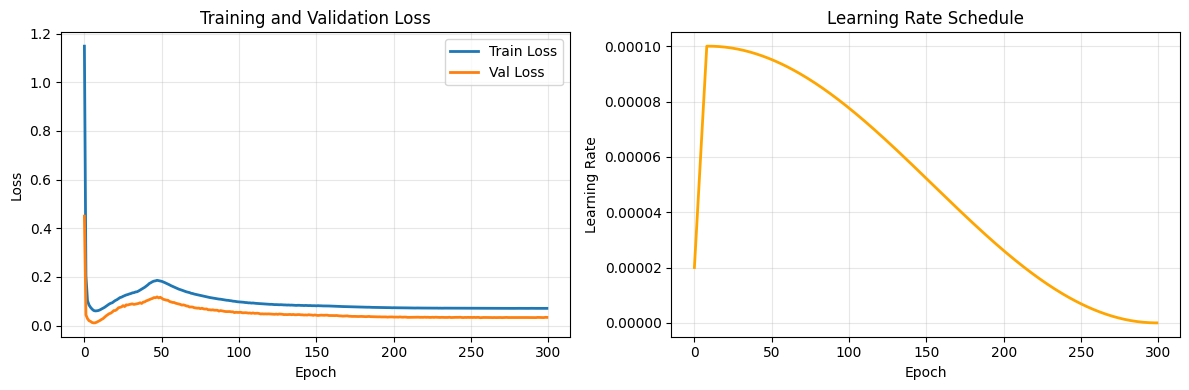


✓ Training complete! Models saved:
  - cosmic_jepa_best.pth (best validation)
  - cosmic_jepa_latest.pth (latest checkpoint)


In [11]:
# ==========================================
# 8. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    print("=" * 60)
    print("COSMIC-JEPA Training Script")
    print("=" * 60)
    
    # Train the model
    model, history = train()
    
    # Plot results if training completed
    if model is not None and history is not None:
        print("\nPlotting training history...")
        plot_training_history(history)
        
        print("\n✓ Training complete! Models saved:")
        print("  - cosmic_jepa_best.pth (best validation)")
        print("  - cosmic_jepa_latest.pth (latest checkpoint)")

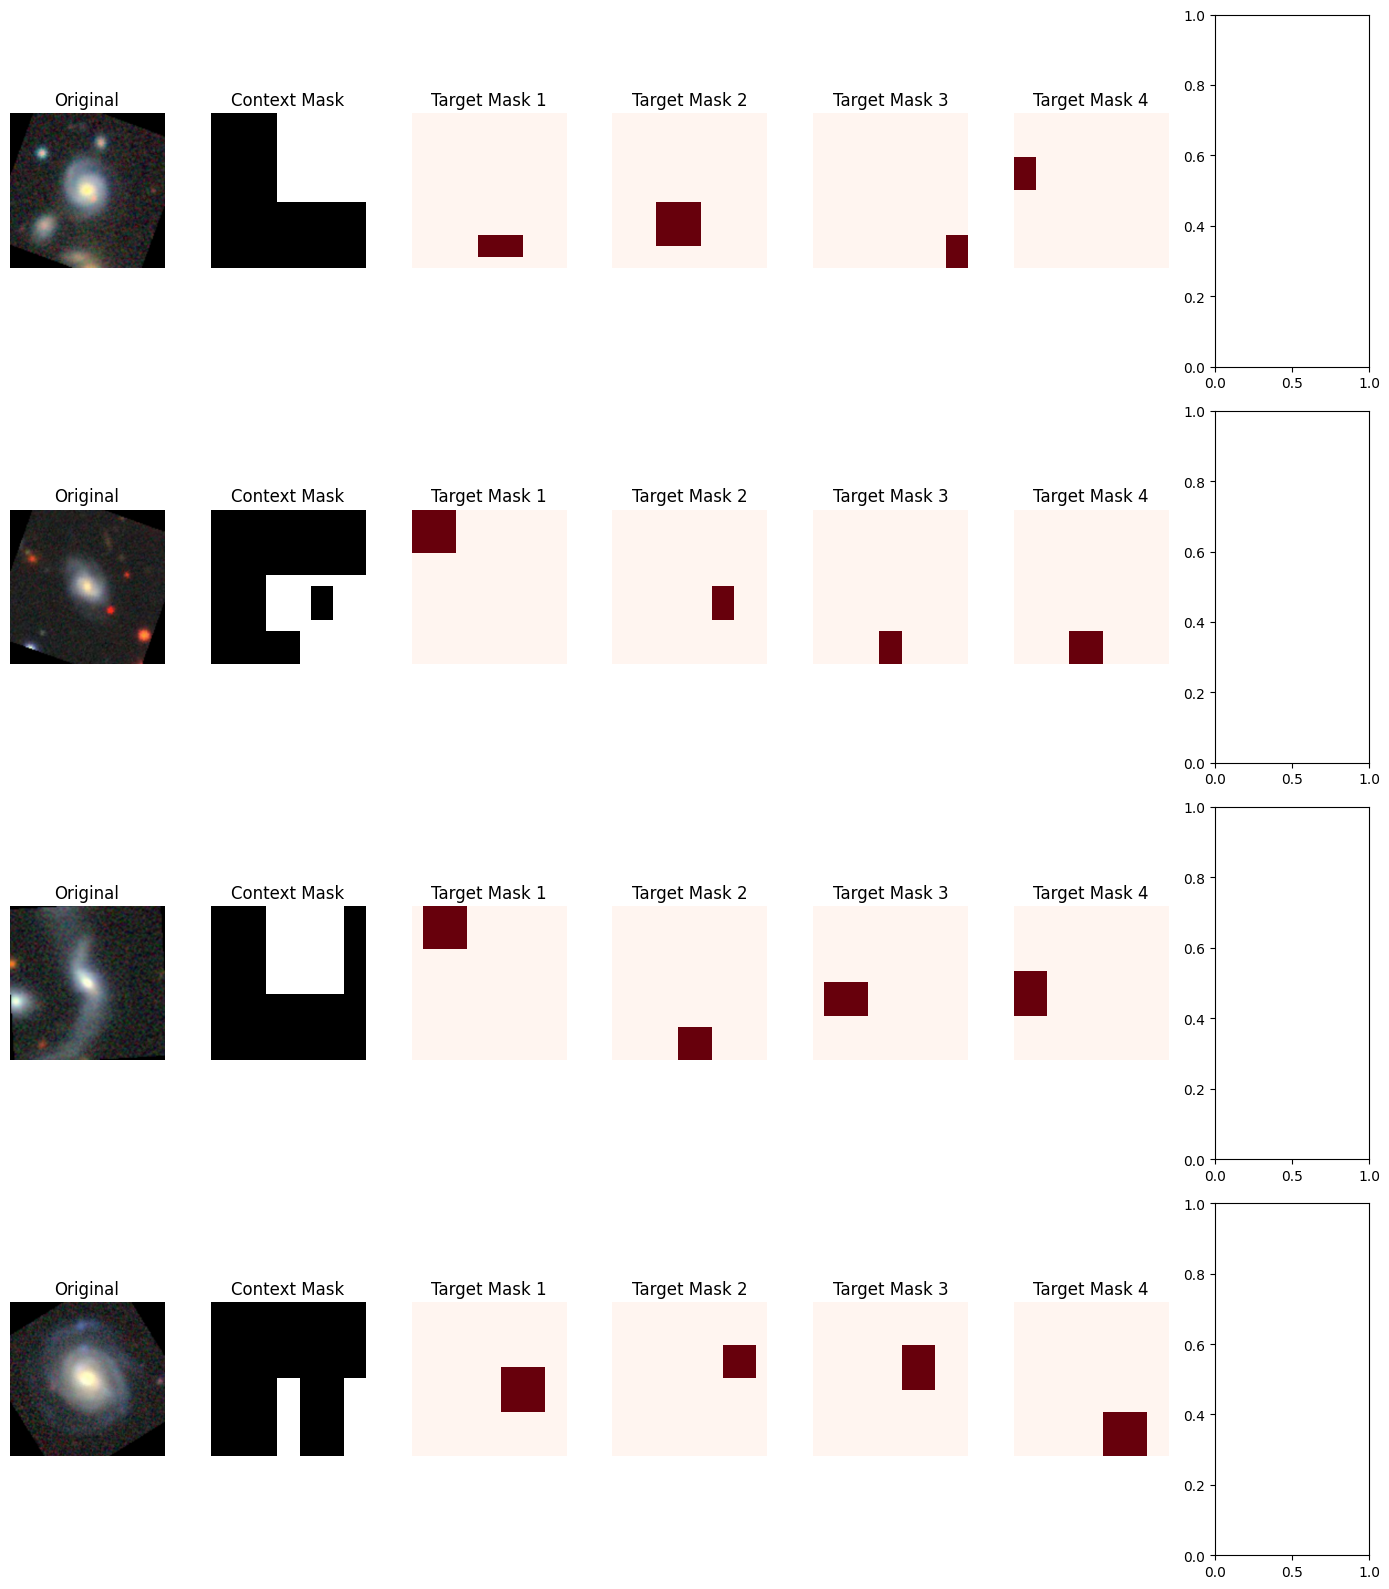

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_batch_from_loader(dataloader, num_samples=4, patch_size=16):
    """
    Visualize a few samples from your JEPA dataloader.
    Shows:
      - Original image
      - Context mask
      - Target masks
    """

    # Get ONE batch
    images, context_mask, target_masks = next(iter(dataloader))

    # Move to CPU numpy
    imgs = images.cpu()
    ctx = context_mask.cpu()
    tgts = [m.cpu() for m in target_masks]

    B = imgs.size(0)
    num_samples = min(num_samples, B)

    # Helper to denormalize for display
    def to_img(t):
        t = t.permute(1,2,0).numpy()
        return (t - t.min()) / (t.max() - t.min() + 1e-5)

    # Patch grid dims
    H = W = int(np.sqrt(ctx.size(1)))

    fig, axes = plt.subplots(num_samples, 3 + len(tgts), figsize=(14, 4*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # ---------------------------
        # Original Image
        # ---------------------------
        img = to_img(imgs[i])
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        # ---------------------------
        # Context Mask
        # ---------------------------
        ctx_mask = ctx[i].reshape(H, W)
        axes[i, 1].imshow(ctx_mask, cmap='gray')
        axes[i, 1].set_title("Context Mask")
        axes[i, 1].axis("off")

        # ---------------------------
        # Target Masks
        # ---------------------------
        for j, tm in enumerate(tgts):
            t_mask = tm[i].reshape(H, W)
            axes[i, 2 + j].imshow(t_mask, cmap="Reds")
            axes[i, 2 + j].set_title(f"Target Mask {j+1}")
            axes[i, 2 + j].axis("off")

    plt.tight_layout()
    plt.show()




show_batch_from_loader(train_loader, num_samples=4, patch_size=16)
